# Business Statement

- Problem solved
    - Hypothesis: non-fraud behavior does not change across time (data has consistent spacial & temporal features)
        - Consistency score as a feature?
 
- Prediction of fraud + the reason for fraud
    - Traditional models (interpretability) vs black-box models

- Current Challenges


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor


# fig, ax = plt.subplots(figsize = (20, 10))

In [2]:
baf_base = pd.read_csv('../Data/Base.csv')

In [3]:
baf_base['fraud_bool'].value_counts()/len(baf_base)*100

0    98.8971
1     1.1029
Name: fraud_bool, dtype: float64

In [4]:
baf_base.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,...,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000,1000000.00000
mean,0.01103,0.56270,0.49369,16.71857,86.58787,33.68908,1.02571,8.66150,1572.69205,5665.29660,...,0.88968,10.83930,0.22299,515.85101,0.02524,7.54494,0.57695,1.01831,0.00000,3.28867
std,0.10444,0.29034,0.28912,44.04623,88.40660,12.02580,5.38183,20.23615,1005.37456,3009.38067,...,0.31329,12.11687,0.41625,487.55990,0.15686,8.03311,0.49404,0.18076,0.00000,2.20999
min,0.00000,0.10000,0.00000,-1.00000,-1.00000,10.00000,0.00000,-15.53055,1.00000,-170.60307,...,0.00000,-1.00000,0.00000,190.00000,0.00000,-1.00000,0.00000,-1.00000,0.00000,0.00000
25%,0.00000,0.30000,0.22522,-1.00000,19.00000,20.00000,0.00719,-1.18149,894.00000,3436.36585,...,1.00000,-1.00000,0.00000,200.00000,0.00000,3.10305,0.00000,1.00000,0.00000,1.00000
50%,0.00000,0.60000,0.49215,-1.00000,52.00000,30.00000,0.01518,-0.83051,1263.00000,5319.76935,...,1.00000,5.00000,0.00000,200.00000,0.00000,5.11432,1.00000,1.00000,0.00000,3.00000
75%,0.00000,0.80000,0.75557,12.00000,130.00000,40.00000,0.02633,4.98418,1944.00000,7680.71783,...,1.00000,25.00000,0.00000,500.00000,0.00000,8.86613,1.00000,1.00000,0.00000,5.00000
max,1.00000,0.90000,1.00000,383.00000,428.00000,90.00000,78.45690,112.95693,6700.00000,16715.56540,...,1.00000,32.00000,1.00000,2100.00000,1.00000,85.89914,1.00000,2.00000,0.00000,7.00000


In [5]:
# This is a binary variable
baf_base['email_is_free'].value_counts()

# Lets look at all the binary variables
binary_cols = baf_base.loc[:,baf_base.isin([0,1]).all()]
binary_cols.head()

,fraud_bool,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,device_fraud_count
0,1,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0
3,1,1,0,1,1,0,0,0
4,1,1,1,0,0,0,1,0


In [6]:
# Define independent & dependent variables
y = baf_base['fraud_bool']
X = baf_base.drop(binary_cols.columns, axis = 1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

# Select only numerical features  
X_train_num = X_train.select_dtypes('number')
X_test_num = X_test.select_dtypes('number')

# Select only categorical features 
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

# Standardize independent variables
scaler = MinMaxScaler()

X_train_std = pd.DataFrame(scaler.fit_transform(X_train_num), columns = X_train_num.columns, index = X_train_num.index)
X_test_std = pd.DataFrame(scaler.transform(X_test_num), columns = X_test_num.columns, index = X_test_num.index)

# One hot encode the categorical variables

X_train_cat_std = pd.get_dummies(X_train_cat, drop_first = True)
X_test_cat_std = pd.get_dummies(X_test_cat, drop_first = True)

# Concat the standardized numerical and one-hot encoded categorical variables

X_train = pd.concat([X_train_std, X_train_cat_std], axis = 1)
X_test = pd.concat([X_test_std, X_test_cat_std], axis = 1)

In [7]:
# Check to see
# X_train.info()
X_train.head()
# Look at histogram X_train vs X_test

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
535020,1.000,0.143900,0.0,0.053613,0.375,0.000460,0.112466,0.088989,0.069982,0.221782,...,0,0,0,0,0,0,0,1,0,0
173350,1.000,0.260371,0.0,0.072261,0.375,0.000049,0.117056,0.173483,0.113875,0.196159,...,1,0,0,0,0,0,0,0,1,0
817262,0.125,0.766793,0.0,0.156177,0.250,0.000249,0.279287,0.567491,0.445266,0.457788,...,0,0,1,0,0,0,0,0,0,0
563903,1.000,0.733825,0.0,0.053613,0.125,0.000041,0.350023,0.151161,0.081587,0.239108,...,1,0,0,0,0,0,0,1,0,0
288729,0.625,0.098534,0.0,0.174825,0.125,0.000276,0.113358,0.309813,0.493019,0.729563,...,0,0,0,0,0,0,0,0,1,0


In [8]:
#SMOTE to fix imbalance
smo = SMOTE()

X_train_smo, y_train_smo = smo.fit_resample(X_train, y_train)
y_train_smo.value_counts()

1    692280
0    692280
Name: fraud_bool, dtype: int64

In [9]:
X_train_smo

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,1.000000,0.143900,0.0,0.053613,0.375000,0.000460,0.112466,0.088989,0.069982,0.221782,...,0,0,0,0,0,0,0,1,0,0
1,1.000000,0.260371,0.0,0.072261,0.375000,0.000049,0.117056,0.173483,0.113875,0.196159,...,1,0,0,0,0,0,0,0,1,0
2,0.125000,0.766793,0.0,0.156177,0.250000,0.000249,0.279287,0.567491,0.445266,0.457788,...,0,0,1,0,0,0,0,0,0,0
3,1.000000,0.733825,0.0,0.053613,0.125000,0.000041,0.350023,0.151161,0.081587,0.239108,...,1,0,0,0,0,0,0,1,0,0
4,0.625000,0.098534,0.0,0.174825,0.125000,0.000276,0.113358,0.309813,0.493019,0.729563,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384555,0.563909,0.777112,0.0,0.159078,0.625000,0.000174,0.275974,0.145244,0.411519,0.391768,...,0,1,0,0,0,0,0,0,1,0
1384556,0.762730,0.218018,0.0,0.052015,0.474539,0.000058,0.396314,0.188159,0.416685,0.426155,...,1,0,0,0,0,0,0,0,0,0
1384557,0.849492,0.356156,0.0,0.246613,0.399238,0.000076,0.900554,0.208339,0.266011,0.263681,...,0,0,0,0,0,0,0,0,1,0
1384558,1.000000,0.282412,0.0,0.057736,0.469955,0.000095,0.113457,0.199718,0.590787,0.670091,...,0,0,0,0,0,0,1,0,0,0


In [10]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
 
# Instantiate
logreg = LogisticRegression(random_state = 42)
 
# Fit the model to training data
model_log = logreg.fit(X_train_smo, y_train_smo)

In [11]:
# Predict on test set
y_test_pred = model_log.predict(X_test)
y_test_proba = model_log.predict_proba(X_test)[:, 1]

In [12]:
# Probability of fraud for each application instance
y_test_proba

array([0.37263041, 0.03848753, 0.14145442, ..., 0.16418692, 0.09350989,
       0.61873725])

Precision: 
- Proportion of applications the model flagged as fradulent which are actually fradulent
- The ratio of True Positive to all the positives predicted by the model

Recall:
- Proportion of all truly fraudulent application which were flagged as fraudulent by our model
- The ratio of True Positives to all the positives in the dataset

In [13]:
#Functions to evaluate threshold based & threshold free metrics

def get_class_from_fraud_probability(fraud_probabilities, threshold=0.5):
    
    predicted_classes = [0 if fraud_probability<threshold else 1 
                         for fraud_probability in fraud_probabilities]

    return predicted_classes


def threshold_based_metrics(fraud_probabilities, true_label, thresholds_list):
    
    results = []
    
    for threshold in thresholds_list:
    
        predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=threshold)
    
        (TN, FP, FN, TP) = confusion_matrix(true_label, predicted_classes).ravel()
    
        MME = (FP+FN)/(TN+FP+FN+TP)
    
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP)
    
        FPR = FP/(TN+FP)
        FNR = FN/(TP+FN)
        
        BER = 1/2*(FPR+FNR)
        
        Gmean = np.sqrt(TPR*TNR)
    
        precision = 0
        FDR = 0
        F1_score=0
        
        if TP+FP>0:
            precision = TP/(TP+FP)
            FDR=FP/(TP+FP)
        
        NPV = 0
        FOR = 0
        
        if TN+FN>0:
            NPV = TN/(TN+FN)
            FOR = FN/(TN+FN)
            
        
        if precision+TPR>0:
            F1_score = 2*(precision*TPR)/(precision+TPR)
    
        results.append([threshold, MME, TPR, TNR, FPR, FNR, BER, Gmean, precision, NPV, FDR, FOR, F1_score])
        
    results_df = pd.DataFrame(results,columns=['Threshold' ,'MME', 'TPR', 'TNR', 'FPR', 'FNR', 'BER', 'G-mean', 'Precision', 'NPV', 'FDR', 'FOR', 'F1 Score'])
    
    return results_df

def evaluate(y_pred, FIXED_FPR = 0.05):
    
    fprs, tprs, thresholds = roc_curve(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fprs, tprs)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]
    threshold = thresholds[fprs<FIXED_FPR][-1]
        
    print("AUC:", roc_auc_score(y_test, y_pred))
    to_pct = lambda x: str(round(x, 4) * 100) + "%"
    print("TPR: ", to_pct(tpr), "\nFPR: ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))

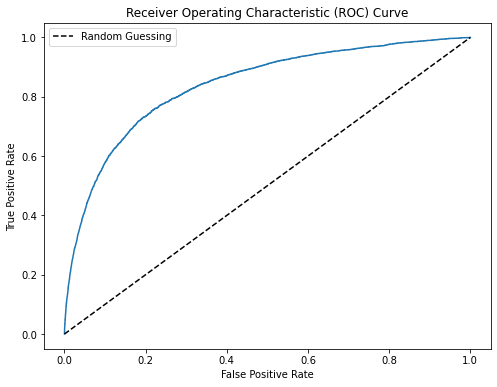

AUC: 0.8392727124191112
TPR:  41.46% 
FPR:  5.0% 
Threshold:  0.81


In [14]:
#AUC ROC Curve
evaluate(y_test_proba)

In [15]:
thresholds = [threshold/10 for threshold in range(0, 10)]
results_df = threshold_based_metrics(y_test_proba, y_test, thresholds)
results_df

,Threshold,MME,TPR,TNR,FPR,FNR,BER,G-mean,Precision,NPV,FDR,FOR,F1 Score
0,0.0,0.988970,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.011030,0.000000,0.988970,0.000000,0.021819
1,0.1,0.762153,0.970384,0.229677,0.770323,0.029616,0.399970,0.472096,0.013855,0.998564,0.986145,0.001436,0.027320
2,0.2,0.559430,0.930493,0.435106,0.564894,0.069507,0.317201,0.636288,0.018040,0.998221,0.981960,0.001779,0.035393
3,0.3,0.408613,0.876398,0.588208,0.411792,0.123602,0.267697,0.717986,0.023186,0.997662,0.976814,0.002338,0.045177
4,0.4,0.297557,0.816259,0.701174,0.298826,0.183741,0.241284,0.756531,0.029564,0.997086,0.970436,0.002914,0.057062
5,0.5,0.216137,0.752795,0.784210,0.215790,0.247205,0.231497,0.768342,0.037451,0.996497,0.962549,0.003503,0.071352
6,0.6,0.153260,0.668782,0.848725,0.151275,0.331218,0.241247,0.753400,0.046990,0.995666,0.953010,0.004334,0.087810
7,0.7,0.101273,0.572076,0.902370,0.097630,0.427924,0.262777,0.718487,0.061344,0.994739,0.938656,0.005261,0.110805
8,0.8,0.058913,0.429737,0.946790,0.053210,0.570263,0.311737,0.637864,0.082631,0.993327,0.917369,0.006673,0.138610
9,0.9,0.025653,0.234210,0.982601,0.017399,0.765790,0.391594,0.479724,0.130537,0.991383,0.869463,0.008617,0.167640


In [16]:
performance_metrics=threshold_based_metrics(y_test_proba, y_test, thresholds)
performance_metrics[['Threshold','Precision','TPR']]

,Threshold,Precision,TPR
0,0.0,0.011030,1.000000
1,0.1,0.013855,0.970384
2,0.2,0.018040,0.930493
3,0.3,0.023186,0.876398
4,0.4,0.029564,0.816259
5,0.5,0.037451,0.752795
6,0.6,0.046990,0.668782
7,0.7,0.061344,0.572076
8,0.8,0.082631,0.429737
9,0.9,0.130537,0.234210


In [21]:
# Average Precision

def compute_AP(precision, recall):
    
    AP = 0
    
    n_thresholds = len(precision)
    
    for i in range(1, n_thresholds):
        
        if recall[i]-recall[i-1]>=0:
            
            AP = AP+(recall[i]-recall[i-1])*precision[i]
        
    return AP

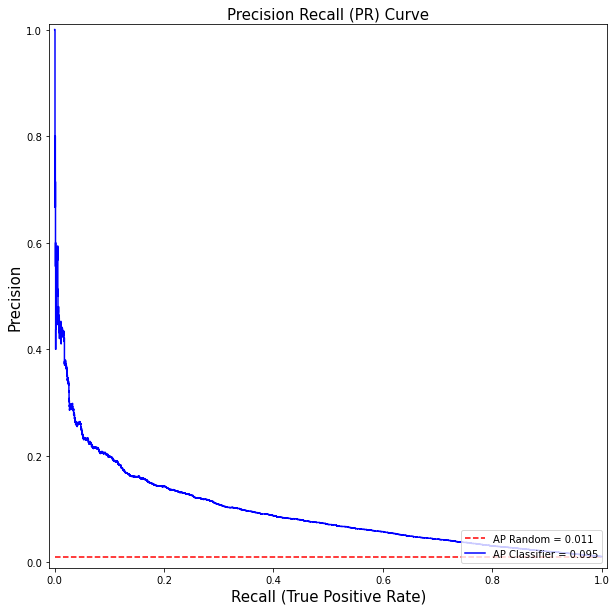

In [18]:
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))


    
precision, recall, threshold = precision_recall_curve(y_test, y_test_proba)
precision=precision[::-1]
recall=recall[::-1]
    
pr_curve, ax = plt.subplots(figsize=(10,10))
get_template_pr_curve(ax, "Precision Recall (PR) Curve",fs=15,baseline=sum(y_test)/len(y_test))
AP2 = average_precision_score(y_test, y_test_proba)
AP = compute_AP(precision, recall)
ax.step(recall, precision, 'b', color='blue', label = 'AP Classifier = {0:0.3f}'.format(AP))
ax.legend(loc = 'lower right')

In [28]:
y_train_pred = model_log.predict(X_train_smo)


Accuracy: 0.78
Precision: 0.78
Recall: 0.77
F1 Score: 0.78
Confusion Matrix:


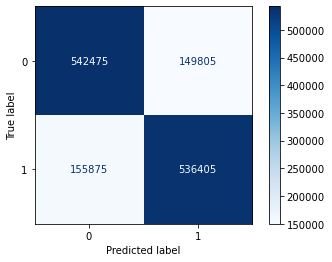

In [30]:
accuracy = accuracy_score(y_train_smo, y_train_pred)
precision = precision_score(y_train_smo, y_train_pred)
recall = recall_score(y_train_smo, y_train_pred)
f1 = f1_score(y_train_smo, y_train_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
 
cnf_matrix = confusion_matrix(y_train_smo, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)

In [22]:
classifier = DecisionTreeClassifier(max_depth = 10, random_state=10)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=10)

In [23]:
# Predict on test set
y_test_pred = classifier.predict(X_test)
y_test_proba = classifier.predict_proba(X_test)[:, 1]

In [25]:
thresholds = [threshold/10 for threshold in range(0, 10)]
results_df = threshold_based_metrics(y_test_proba, y_test, thresholds)
results_df

,Threshold,MME,TPR,TNR,FPR,FNR,BER,G-mean,Precision,NPV,FDR,FOR,F1 Score
0,0.0,0.988970,1.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.011030,0.000000,0.988970,0.000000,0.021819
1,0.1,0.018523,0.112421,0.991169,0.008831,0.887579,0.448205,0.333808,0.124332,0.990111,0.875668,0.009889,0.118076
2,0.2,0.013253,0.050166,0.997192,0.002808,0.949834,0.476321,0.223664,0.166166,0.989488,0.833834,0.010512,0.077066
3,0.3,0.012323,0.030221,0.998355,0.001645,0.969779,0.485712,0.173698,0.170068,0.989282,0.829932,0.010718,0.051322
4,0.4,0.011787,0.015715,0.999060,0.000940,0.984285,0.492613,0.125299,0.157100,0.989131,0.842900,0.010869,0.028571
5,0.5,0.011690,0.015413,0.999161,0.000839,0.984587,0.492713,0.124095,0.170000,0.989129,0.830000,0.010871,0.028263
6,0.6,0.011607,0.010577,0.999299,0.000701,0.989423,0.495062,0.102810,0.144033,0.989078,0.855967,0.010922,0.019707
7,0.7,0.011583,0.009973,0.999329,0.000671,0.990027,0.495349,0.099830,0.142241,0.989072,0.857759,0.010928,0.018639
8,0.8,0.011553,0.009973,0.999360,0.000640,0.990027,0.495334,0.099832,0.147982,0.989072,0.852018,0.010928,0.018686
9,0.9,0.011543,0.009368,0.999376,0.000624,0.990632,0.495628,0.096760,0.143519,0.989065,0.856481,0.010935,0.017589


In [24]:
# #Feature Selection

# cat_names = list(cat_df.columns)
# higher_corrs = ['income', 'customer_age', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'has_other_cards', 'proposed_credit_limit', 'keep_alive_session']

# X_train_smo = X_train_smo[cat_names + higher_corrs]
# X_test_smo = X_test_smo[cat_names + higher_corrs]

# EDA (Data Understanding):

# Data Processing

- Nulls
- Apply filters to realize our assumptions
- Standardize variables
- SMOTE to balance target
- Train/Test split


# Features

Types:
- Account related features: account number, card exp date, etc.
- Transaction related features: POS number, transaction time, amount, etc.
- Customer related features: customer number, type of customer, etc.

Feature transformation:
- Date/time variables: weekday or weekend
- Customer spending: average spending amount  + number of transactions
- Risk score: average number of fraud over a certain window 

In [ ]:
# def generate_customer_profiles_table(n_customers, random_state=0):
    
#     np.random.seed(random_state)
        
#     customer_id_properties=[]
    
#     # Generate customer properties from random distributions 
#     for customer_id in range(n_customers):
        
#         x_customer_id = np.random.uniform(0,100)
#         y_customer_id = np.random.uniform(0,100)
        
#         mean_amount = np.random.uniform(5,200) # Arbitrary (but sensible) value 
#         std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
#         mean_nb_tx_per_day = np.random.uniform(0,5) # Arbitrary (but sensible) value 
        
#         customer_id_properties.append([customer_id,
#                                       x_customer_id, y_customer_id,
#                                       mean_amount, std_amount,
#                                       mean_nb_tx_per_day])
        
#     customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
#                                                                       'x_customer_id', 'y_customer_id',
#                                                                       'mean_amount', 'std_amount',
#                                                                       'mean_nb_tx_per_day'])
    
#     return customer_profiles_table

# def generate_terminal_profiles_table(n_terminals, random_state=0):
    
#     np.random.seed(random_state)
        
#     terminal_id_properties=[]
    
#     # Generate terminal properties from random distributions 
#     for terminal_id in range(n_terminals):
        
#         x_terminal_id = np.random.uniform(0,100)
#         y_terminal_id = np.random.uniform(0,100)
        
#         terminal_id_properties.append([terminal_id,
#                                       x_terminal_id, y_terminal_id])
                                       
#     terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
#                                                                       'x_terminal_id', 'y_terminal_id'])
    
#     return terminal_profiles_table

# def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
#     # Use numpy arrays in the following to speed up computations
    
#     # Location (x,y) of customer as numpy array
#     x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
#     # Squared difference in coordinates between customer and terminal locations
#     squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
#     # Sum along rows and compute suared root to get distance
#     dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
#     # Get the indices of terminals which are at a distance less than r
#     available_terminals = list(np.where(dist_x_y<r)[0])
    
#     # Return the list of terminal IDs
#     return available_terminals

In [ ]:
# def generate_transactions_table(customer_profile, start_date = "2023-05-01", nb_days = 10):
    
#     customer_transactions = []
    
#     random.seed(int(customer_profile.CUSTOMER_ID))
#     np.random.seed(int(customer_profile.CUSTOMER_ID))
    
#     # For all days
#     for day in range(nb_days):
        
#         # Random number of transactions for that day 
#         nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
#         # If nb_tx positive, let us generate transactions
#         if nb_tx>0:
            
#             for tx in range(nb_tx):
                
#                 # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
#                 # most transactions occur during the day.
#                 time_tx = int(np.random.normal(86400/2, 20000))
                
#                 # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
#                 if (time_tx>0) and (time_tx<86400):
                    
#                     # Amount is drawn from a normal distribution  
#                     amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
#                     # If amount negative, draw from a uniform distribution
#                     if amount<0:
#                         amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
#                     amount=np.round(amount,decimals=2)
                    
#                     if len(customer_profile.available_terminals)>0:
                        
#                         terminal_id = random.choice(customer_profile.available_terminals)
                    
#                         customer_transactions.append([time_tx+day*86400, day,
#                                                       customer_profile.CUSTOMER_ID, 
#                                                       terminal_id, amount])
            
#     customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
#     if len(customer_transactions)>0:
#         customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
#         customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
#     return customer_transactions  

# def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2023-05-01", r=5):
    
#     start_time=time.time()
#     customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
#     print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
#     start_time=time.time()
#     terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
#     print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
#     start_time=time.time()
#     x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
#     customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
#     # With Pandarallel
#     #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
#     customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
#     print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
#     start_time=time.time()
#     transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
#     # With Pandarallel
#     #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
#     print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
#     # Sort transactions chronologically
#     transactions_df=transactions_df.sort_values('TX_DATETIME')
#     # Reset indices, starting from 0
#     transactions_df.reset_index(inplace=True,drop=True)
#     transactions_df.reset_index(inplace=True)
#     # TRANSACTION_ID are the dataframe indices, starting from 0
#     transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
#     return (customer_profiles_table, terminal_profiles_table, transactions_df)
    
# def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
#     # By default, all transactions are genuine
#     transactions_df['TX_FRAUD']=0
#     transactions_df['TX_FRAUD_SCENARIO']=0
    
#     # Scenario 1
#     transactions_df.loc[transactions_df.TX_AMOUNT>450, 'TX_FRAUD']=1
#     transactions_df.loc[transactions_df.TX_AMOUNT>450, 'TX_FRAUD_SCENARIO']=1
#     nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
#     print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
#     # Scenario 2
#     for day in range(transactions_df.TX_TIME_DAYS.max()):
        
#         compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
#         compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
#                                                     (transactions_df.TX_TIME_DAYS<day+28) & 
#                                                     (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
#         transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
#         transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
#     nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
#     print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
#     # Scenario 3
#     for day in range(transactions_df.TX_TIME_DAYS.max()):
        
#         compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
#         compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
#                                                     (transactions_df.TX_TIME_DAYS<day+14) & 
#                                                     (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
#         nb_compromised_transactions=len(compromised_transactions)
        
        
#         random.seed(day)
#         index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
#         transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
#         transactions_df.loc[index_fauds,'TX_FRAUD']=1
#         transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
#     nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
#     print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
#     return transactions_df

In [ ]:
# (customer_profiles_table, terminal_profiles_table, transactions_df)=\
#     generate_dataset(n_customers = 5000, 
#                      n_terminals = 10000, 
#                      nb_days=180, 
#                      start_date="2023-05-01", 
#                      r=5)

In [ ]:
# distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

# amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
# time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

# sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
# ax[0].set_title('Distribution of transaction amounts', fontsize=14)
# ax[0].set_xlim([min(amount_val), max(amount_val)])
# ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# # We divide the time variables by 86400 to transform seconds to days in the plot
# sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
# ax[1].set_title('Distribution of transaction times', fontsize=14)
# ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
# ax[1].set_xticks(range(10))
# ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

In [ ]:
# %time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

# transactions_df.columns = ['TRANSACTION_ID', 'DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
#        'AMOUNT', 'TIME_SECONDS', 'TIME_DAYS', 'FRAUD',
#        'FRAUD_SCENARIO']

# transactions_df.to_csv('cc_transactions.csv', index = False)

# Baseline Model

- Logistic Regression 
    - Coefficients, statisitcal importance, explainability
- Decision Tree
    - Classification criteria, feature importance

# Evaluation

- Metrics: ROC (AUC Score), Recall, Confusion Matrix

# Hyperparameter Tuning --> Optimal Model

- Ensemble Methods:
    - Random Forest
    - Boosting

# Conclusion